In [1]:
# Numerical libraries
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# MD Stuff
import MDAnalysis as mda

# Utils
from tqdm import tqdm
import pickle

# SBI
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


# Functions for generating images

In [4]:
def gen_quat(size):
    #Sonya's code
    
    #np.random.seed(0)
    quaternions = np.zeros((size, 4))
    count = 0

    while count < size:

        quat = np.random.uniform(-1,1,4) #note this is a half-open interval, so 1 is not included but -1 is
        norm = np.sqrt(np.sum(quat**2))

        if ( 0.2 <= norm <= 1.0 ):
            quaternions[count] = quat/norm
            count += 1

    return quaternions

def gen_img(coord, args_dict):
    
    n_atoms = coord.shape[1]
    norm = 1 / (2 * np.pi * args_dict["SIGMA"]**2 * n_atoms)

    grid_min = -args_dict["PIXEL_SIZE"] * (args_dict["N_PIXELS"] - 1)*0.5
    grid_max = args_dict["PIXEL_SIZE"] * (args_dict["N_PIXELS"] - 1)*0.5 + args_dict["PIXEL_SIZE"]

    grid = np.arange(grid_min, grid_max, args_dict["PIXEL_SIZE"])

    gauss = np.exp( -0.5 * ( ((grid[:,None] - coord[0,:]) / args_dict["SIGMA"])**2) )[:,None] * \
            np.exp( -0.5 * ( ((grid[:,None] - coord[1,:]) / args_dict["SIGMA"])**2) )

    image = gauss.sum(axis=2) * norm

    return image

def load_model(fname, filter = "name CA"):

    mda_model = mda.Universe(fname)

    # Center model
    #mda_model.atoms.translate(-mda_model.select_atoms('all').center_of_mass())

    # Extract coordinates
    coordinates = mda_model.select_atoms(filter).positions.T

    return coordinates

# Functions for post-processing the images

In [5]:
def add_noise(img, snr):

    #mean_image = np.mean(img)
    std_image = np.std(img)

    mask = np.abs(img) > 0.5 * std_image

    signal_mean = np.mean(img[mask])
    signal_std = np.std(img[mask])

    noise_std = signal_std / np.sqrt(snr)
    noise = np.random.normal(loc=signal_mean, scale=noise_std, size=img.shape)

    img_noise = img + noise

    img_noise -= np.mean(img_noise)
    img_noise /= np.std(img_noise)

    # img_noise = np.zeros_like(img)
    # img_noise[mask] = img[mask]
    
    return img_noise

def add_noise_to_dataset(dataset, args_dict, snr):

    images_with_noise = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        image_with_noise = add_noise(
            dataset[i].reshape(args_dict["N_PIXELS"], args_dict["N_PIXELS"]).numpy(),
            args_dict["N_PIXELS"],
            args_dict["PIXEL_SIZE"],
            snr)

        images_with_noise[i] = torch.tensor(image_with_noise.reshape(args_dict["N_PIXELS"]**2))

    return images_with_noise

def normalize_dataset(dataset):

    norm_images = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        mu = torch.mean(dataset[i])
        sigma = torch.std(dataset[i])

        norm_images[i] = (dataset[i] - mu) / sigma

    return norm_images

# Generating data

I only generate images for models with name ```models/state_1_*.txt```. If you want to generate different models change the 43rd line in ```simulate_for_sbi_cpp``` (one cell above).

In [6]:
prior_indices = utils.BoxUniform(low=1*torch.ones(1), high=20*torch.ones(1))

In [7]:
args_dict = {"PIXEL_SIZE": 1,
             "N_PIXELS": 128,
             "SIGMA": 1.0
             }

def simulator(index):

    index1 = int(np.round(index))

    coord = load_model(f"models/state_1_{index1}.pdb")

    quat = gen_quat(1)[0]
    rot_mat = Rotation.from_quat(quat).as_matrix()
    coord = np.matmul(rot_mat, coord)

    image = gen_img(coord, args_dict)
    image = add_noise(image, 0.1)

    return image

simulator_sbi, prior_sbi = prepare_for_sbi(simulator, prior_indices)

In [22]:
indices, images = simulate_for_sbi(
    simulator_sbi,
    proposal=prior_sbi,
    num_simulations=10000,
    num_workers=32
    )

Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
torch.save(images, "images_rot_noise_01_128.pt")
torch.save(indices, "indices_rot_noise_01_128.pt")

In [ ]:
images = torch.load("images_no_rot_clean.pt")
indices = torch.load("indices_no_rot_clean.pt")

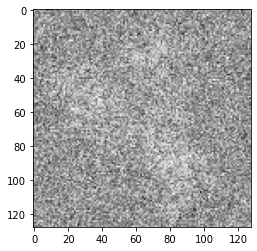

In [24]:
plt.imshow(images[0].reshape(128, 128), cmap="Greys_r")

# Training SBI's neural network


In [25]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=100, num_transforms=8)
inference = SNPE(prior=prior_indices, density_estimator=density_estimator_build_fun)

In [26]:
# Calculate and save posterior
#posteriors = {}

""" 
# Train multiple posteriors for different noise levels
snr_training = [0.1]

for snr in snr_training:
    
    ##### Post processing images #####
    images_with_noise = add_noise_to_dataset(images, args_dict, snr) 
    images_with_noise = normalize_dataset(images_with_noise)
    ##### Post processing images #####
    
    inference = inference.append_simulations(indices, images_with_noise)

    density_estimator = inference.train()
    posteriors[f"snr_{snr}"] = inference.build_posterior(density_estimator) """

    
inference = inference.append_simulations(indices, images)

density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

/mnt/home/dsilvasanchez/virtual_envs/sbi_env/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 21 epochs.

In [27]:
with open("posteriors_rot_new_noise_128.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [2]:
with open("posteriors_rot_new_noise_128.pkl", "rb") as handle:
    posterior = pickle.load(handle)

In [11]:
true_index = prior_sbi.sample((1,))
true_image = simulator_sbi(true_index)

In [12]:
n_samples = 20000

samples = posterior.sample((n_samples,), x=true_image)  

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

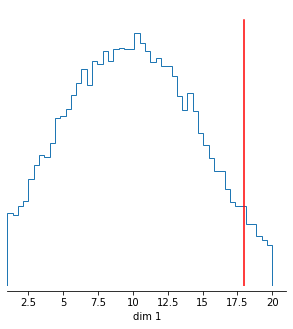

In [13]:
fig, axes = analysis.pairplot(samples,
                           limits=[[1,21], [1,21]],
                           #ticks=[[2,10], [2,10]],
                           figsize=(5,5),
                           points=true_index.round(),
                           points_offdiag={'markersize': 6},
                           points_colors='r');